На основе ноутбука с примером из лекции (segmentation.ipynb) написать свою версию Unet (заготовка для задачи - segmentation_by_hands.ipynb) - слои должны создаваться вручную, работа ведется с датасетом oxford_iiit_pet. Глобально менять архитектуру сети нельзя. Можно добавлять слои (но только вручную), менять функции активации, функцию ошибки, размеры batch и количество эпох. Цель - добиться от нейросети из segmentation_by_hands точности не ниже, чем для нейросети из segmentation при 20 эпохах.

In [31]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
from tensorflow import keras
from tensorflow.keras import activations
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras import utils

In [32]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

In [33]:
# Функции для предобработки изображений из датасета

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [34]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [35]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [36]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [37]:
# Формируем обучающие и тестовые батчи выборок

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [38]:
def display(display_list):
    """Отображает исходное изображение и её эталонную маску."""
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

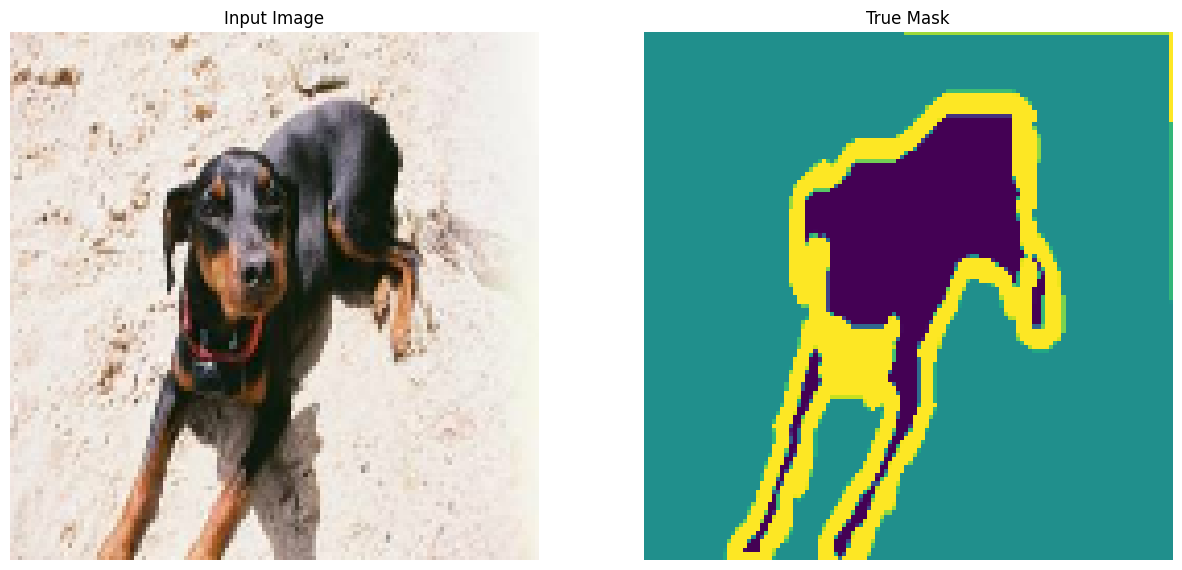

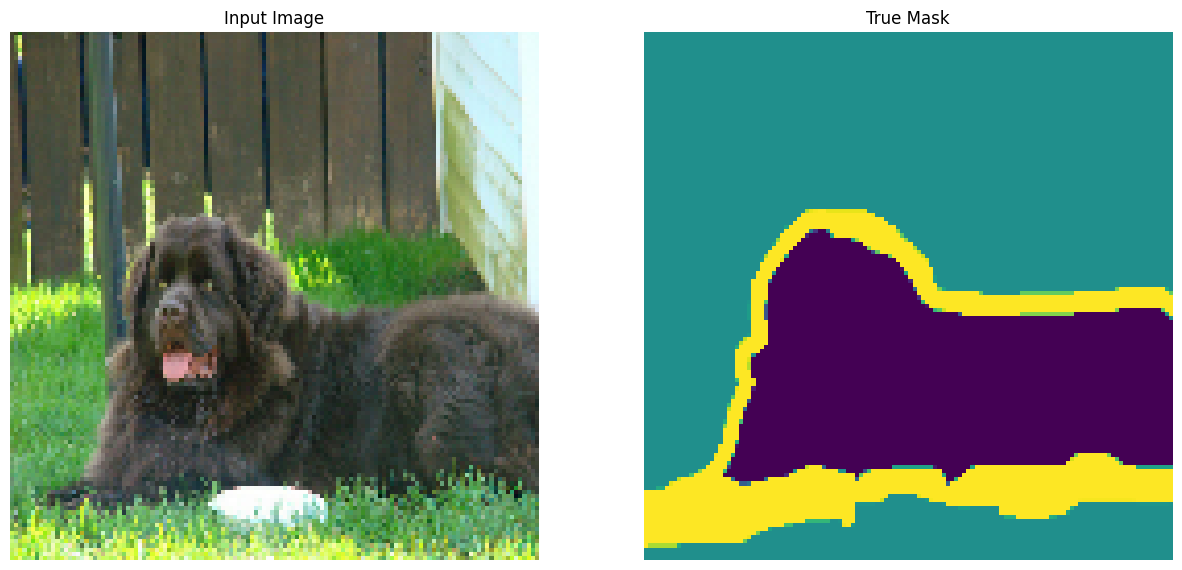

In [39]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [40]:
class DisplayCallback(tf.keras.callbacks.Callback):
    """Класс для отображения процесса обучения."""
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [41]:
def my_unet_model(output_channels: int):
    """Формирует объект модели для предсказаний."""
    inputs = Input(shape=(128, 128, 3))
    
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    b = Dropout(0.3)(b)
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    u1 = UpSampling2D((2, 2), interpolation='bilinear')(b)
    u1 = Concatenate()([u1, c3])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    u2 = UpSampling2D((2, 2), interpolation='bilinear')(c4)
    u2 = Concatenate()([u2, c2])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    u3 = UpSampling2D((2, 2), interpolation='bilinear')(c5)
    u3 = Concatenate()([u3, c1])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(c6)

    return Model(
        inputs=inputs, 
        outputs=Conv2D(output_channels, (1, 1), activation=None, padding='same')(c6),
    )

In [42]:
OUTPUT_CLASSES = 3
model = my_unet_model(OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


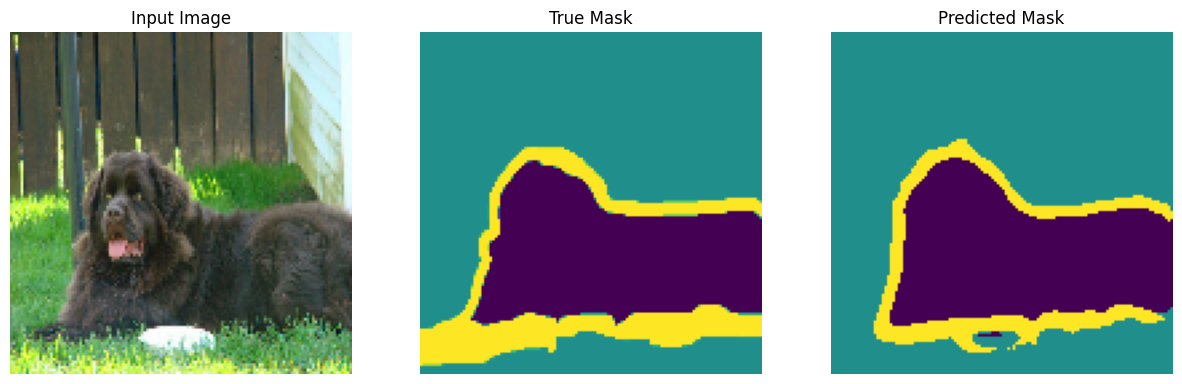


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8509 - loss: 0.3622 - val_accuracy: 0.8527 - val_loss: 0.3631


In [43]:
# На этой ячейке производится обучение модели

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()]
)

In [44]:
# Функции для отображения полученных от модели предсказаний

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


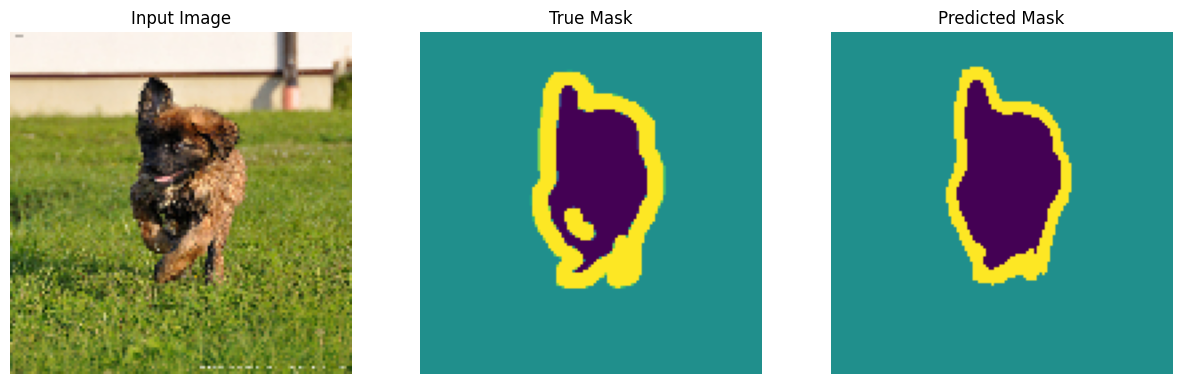

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


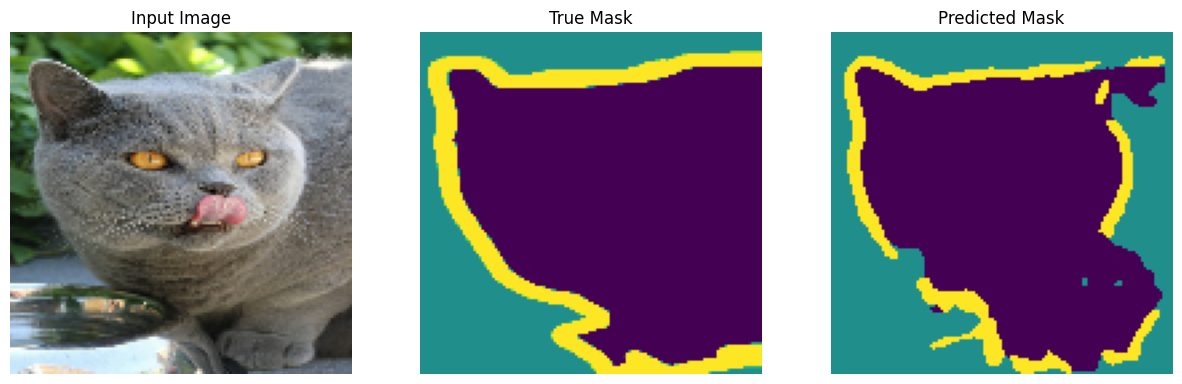

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


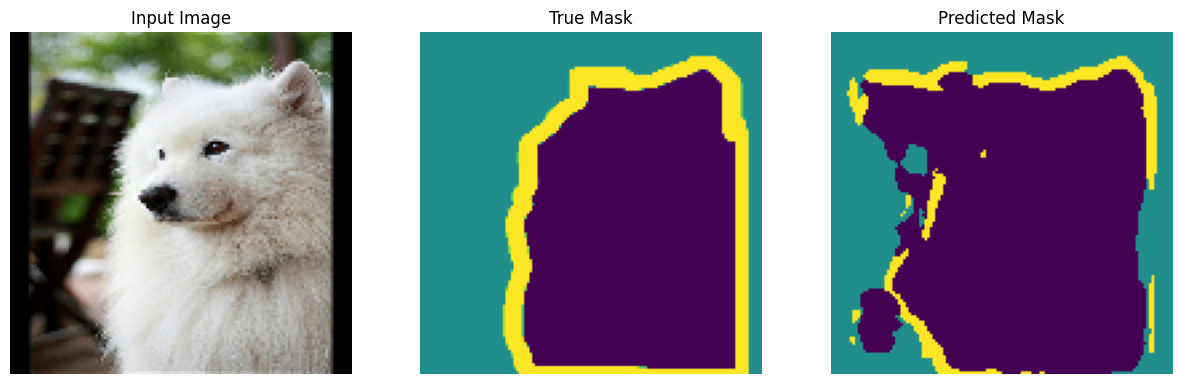

In [45]:
show_predictions(test_batches, 3)